In [33]:
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [6]:
# Initialize Earth Engine
ee.Initialize()
dY=dX=1.5
lat = 45.092
lon = 55.082
# Coordinate mapping for rectangle of plume
grid_pt = (lat, lon)
dlat = dY/110.574
dlon = dX/111.320/np.cos(lat*0.0174532925)
print('dlat, dlon: ', dlat, dlon)
W=grid_pt[1]-dlon 
E=grid_pt[1]+dlon
N=grid_pt[0]+dlat
S=grid_pt[0]-dlat
re   = ee.Geometry.Point(lon, lat)
region = ee.Geometry.Polygon(
    [[W, N],\
    [W, S],\
    [E, S],\
    [E, N]])

era5_region = ee.Geometry.Polygon(
        [[lon-dlon, lat+dlat],\
          [lon-dlon, lat-dlat],\
          [lon+dlon, lat-dlat],\
          [lon+dlon, lat+dlat]])

redband = 'B4'
greenband = 'B3'
blueband = 'B2'
nirband = 'B8'
swir1band = 'B11'
swir2band = 'B12'
cloudband = 'QA60'

dlat, dlon:  0.01356557599435672 0.019086729896443874


In [11]:
def get_s2_cld_col(aoi, start_date, end_date):
    ## Import and filter S2.
    # s2_sr_col = (ee.ImageCollection('COPERNICUS/S2')
    #     .filterMetadata('MGRS_TILE', 'equals', '31SGR')
    #     .filterBounds(aoi)
    #     .filterDate(start_date, end_date)
    #     )

    # Import and filter S2.
    s2_sr_col_all = (ee.ImageCollection('COPERNICUS/S2')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        )
#     mgsr_list = s2_sr_col_all.aggregate_array('MGRS_TILE').getInfo()
#     print('mgsr_list: ', mgsr_list)
#     if len(mgsr_list) == 0:
#         return None
#     s2_sr_col = s2_sr_col_all.filterMetadata('MGRS_TILE', 'equals', mgsr_list[0])
#     s2_sr_img_size = s2_sr_col.size().getInfo()
#     print(mgsr_list[0] + ' size: ', s2_sr_img_size)

#     for tile in mgsr_list[1:]:
#         s2_sr_col_tmp = s2_sr_col_all.filterMetadata('MGRS_TILE', 'equals', tile)
#         current_size = s2_sr_col_tmp.size().getInfo()
#         print(tile + ' size: ', current_size)
#         if current_size > s2_sr_img_size:
#             s2_sr_img_size = current_size
#             s2_sr_col = s2_sr_col_all.filterMetadata('MGRS_TILE', 'equals', tile)
    
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col_all,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability').rename('cloud_prob')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb]))

In [14]:
_default_value = None
scaleFac = 0.0001
img_collection = get_s2_cld_col(region, '2020-09-21', '2020-09-22')
img_collection = img_collection.map(add_cloud_bands).select([redband,
                                greenband,
                                blueband,
                                nirband,
                                swir1band,
                                swir2band,
                                'cloud_prob'])

mgsr_list = img_collection.aggregate_array('MGRS_TILE').getInfo()
print(mgsr_list)

['40TCQ', '40TCR']


In [39]:
scaleFac = 0.0001
_default_value = None

collectionList = img_collection.toList(img_collection.size())
currentimg = ee.Image(collectionList.get(1))
imgdate = datetime(1970, 1, 1, 0, 0) + timedelta(seconds=currentimg.date().getInfo()['value']/1000)
B6channel = currentimg.select(swir1band).multiply(0.0001)
B7channel = currentimg.select(swir2band).multiply(0.0001)

SWIR1img = B6channel.reproject(crs=ee.Projection('EPSG:3395'), scale=30)
SWIR2img = B7channel.reproject(crs=ee.Projection('EPSG:3395'), scale=30)

# To numpy array
SWIR1_geemap = geemap.ee_to_numpy(SWIR1img, region=region, default_value=None)
SWIR2_geemap = geemap.ee_to_numpy(SWIR2img, region=region, default_value=None)


swir1channel = currentimg.select(swir1band).multiply(0.0001).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
swir1channel = np.squeeze(geemap.ee_to_numpy(swir1channel, region=region, default_value=None))




bchannel = currentimg.select(blueband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
bchannel = np.squeeze(geemap.ee_to_numpy(bchannel, region=region, default_value=_default_value))

gchannel = currentimg.select(greenband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
gchannel = np.squeeze(geemap.ee_to_numpy(gchannel, region=region, default_value=_default_value))

rchannel = currentimg.select(redband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
rchannel = np.squeeze(geemap.ee_to_numpy(rchannel, region=region, default_value=_default_value))

In [36]:
np.any(SWIR1_geemap == None)

False

2020-09-21 07:17:06.129000
2020-09-21 07:17:06.129000


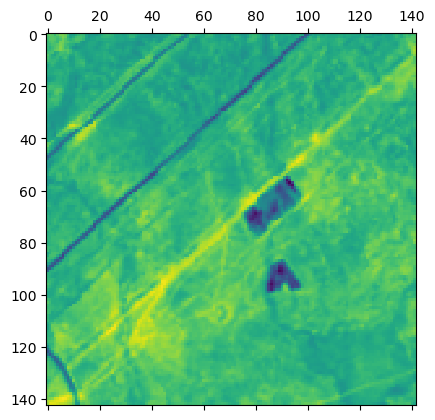

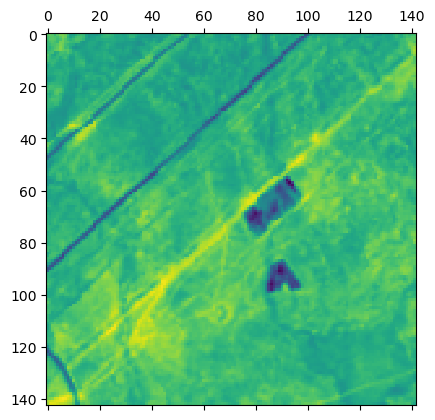

In [38]:
plt.matshow(SWIR1_geemap)
print(imgdate)

plt.matshow(swir1channel)
print(imgdate)

In [41]:
df = np.load('labelled_plumes/55.082_45.092/S2_55.082Ex45.092N_20200921_071720_imgMonID8/S2_55.082Ex45.092N_20200921_071720_imgMonID8.npz')

In [46]:
channels = df['channels']
print(channels.shape)

(143, 142, 8)


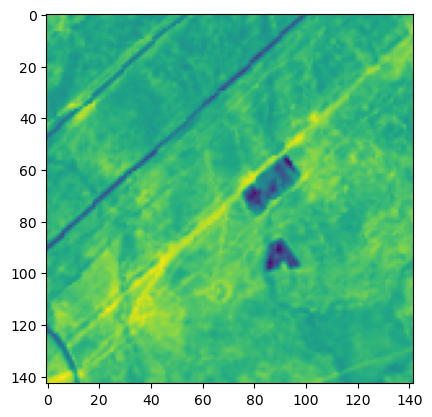

In [52]:
plt.imshow(channels[:, :, 5])